# DEEP LEARNING WITH PYTHON
## _FROM TABULAR TO MULTIMEDIA_

### UniFr Winter School in Data Analytics & Machine Learning
Fribourg, 14-16 February 2024

with [Christian Kauth](https://www.linkedin.com/in/ckauth/)

# [MediaPipe Studio](https://mediapipe-studio.webapps.google.com/home) (Google)

## Webcam Access

Use colab's code snippet to find camera capture!

### JS Code

In [ ]:
from IPython.display import display, Javascript

def video_stream():
  js = Javascript('''

    var div;
    var video_original;
    var image_meshed;
    var stream;
    var is_stopped = false;

    async function startVideoStream() {
      div = document.createElement('div');
      const button_stop = document.createElement('button');
      button_stop.textContent = 'Stop';
      button_stop.addEventListener("click", function() {
        stopVideoStream();
      });

      video_original = document.createElement('video');
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      video_original.srcObject = stream;

      image_meshed = document.createElement('img');

      document.body.appendChild(div);
      div.appendChild(button_stop);
      div.appendChild(video_original);
      div.appendChild(image_meshed);

      await video_original.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
    }

    async function stopVideoStream() {
      stream.getTracks().forEach(function(track) {
        track.stop();
      });
      //div.remove();
      is_stopped = true;
    }

    async function getFrame(quality=0.8) {
      if (is_stopped) {
        return '';
      }
      const canvas = document.createElement('canvas');
      canvas.width = video_original.videoWidth;
      canvas.height = video_original.videoHeight;
      canvas.getContext('2d').drawImage(video_original, 0, 0);
      return canvas.toDataURL('image/jpeg', quality);
    }

    async function setFrame(frame_js) {
      image_meshed.src = frame_js
    }

    ''')
  display(js)

### Python Code

In [ ]:
from google.colab.output import eval_js

from base64 import b64decode, b64encode
import numpy as np
import cv2

def start_video_stream():
  eval_js('startVideoStream()')

def stop_video_stream():
  eval_js('stopVideoStream()')

def get_frame():
  frame_js = eval_js('getFrame()')
  # decode base64 image
  image_bytes = b64decode(frame_js.split(',')[1])
  # convert bytes to numpy array
  img_array = np.frombuffer(image_bytes, dtype=np.uint8)
  # convert numpy array into OpenCV BGR
  frame = cv2.imdecode(img_array, flags=1)
  return frame

def set_frame(frame):
  _, img_array = cv2.imencode('.jpeg', frame)
  image_bytes = np.array(img_array).tobytes()
  frame_js = "data:image/jpeg;base64," + b64encode(image_bytes).decode("utf-8")
  eval_js(f'setFrame("{frame_js}")')

## Face Mesh
from Google's [MediaPipe](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/)

In [ ]:
!pip install -q mediapipe

In [ ]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:

  video_stream()
  start_video_stream()

  while True:
    try:
      image = get_frame()

      # To improve performance, optionally mark the image as not writeable to
      # pass by reference.
      image.flags.writeable = False
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      results = face_mesh.process(image)

      # Draw the face mesh annotations on the image.
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

      if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
          mp_drawing.draw_landmarks(
              image=image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_TESSELATION,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_tesselation_style())
          mp_drawing.draw_landmarks(
              image=image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_CONTOURS,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_contours_style())
          mp_drawing.draw_landmarks(
              image=image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp_drawing_styles
              .get_default_face_mesh_iris_connections_style())
      # Flip the image horizontally for a selfie-view display.
      set_frame(image)

    except:
      break

<IPython.core.display.Javascript object>

# [Vision Studio](https://portal.vision.cognitive.azure.com/gallery/featured) (Microsoft)

## Webcam Access

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


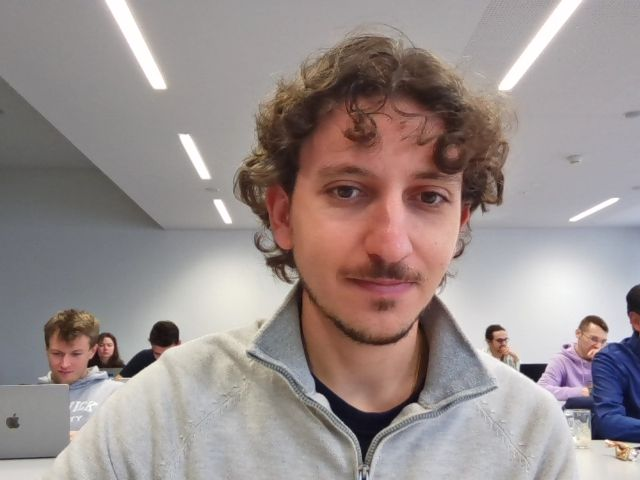

In [3]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Azure Computer Vision
There is a free tier (F), see the [pricing table](https://azure.microsoft.com/en-us/pricing/details/cognitive-services/computer-vision/#pricing)

In [4]:
!pip install -qq azure-cognitiveservices-vision-computervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
e8526f86666149f28d9544c5f280ed52

In [8]:
from google.colab import userdata

vision_endpoint = "https://adamcares-vision-experiment.cognitiveservices.azure.com/"
vision_key = userdata.get("AZURE_VISION_KEY")

Azure vision key here must also be defined as a key in colab.

In [9]:
import requests
import os
import json

subscription_key = vision_key
endpoint = vision_endpoint
image_path = 'photo.jpg'

# Construct the URL for the API call
url = endpoint + "computervision/imageanalysis:segment?api-version=2023-02-01-preview&mode=backgroundRemoval"

# Set up the headers with the subscription key
headers = {
    'Ocp-Apim-Subscription-Key': subscription_key,
    'Content-Type': 'application/octet-stream'
}

# Read the image file in binary mode
with open(image_path, 'rb') as image_data:
    data = image_data.read()

response = requests.post(url, headers=headers, data=data)

# Check for successful response
if response.status_code == 200 or response.status_code == 201:
  image_data = response.content

  # Define the path for the resulting image
  result_image_path = 'photo_no_bg.png'

  # Write the image data to a file
  with open(result_image_path, 'wb') as result_image_file:
      result_image_file.write(image_data)

  print(f"Resulting image saved to {result_image_path}")
else:
  print(f"Failed to submit request: {response.status_code}, {response.text}")

Resulting image saved to photo_no_bg.png


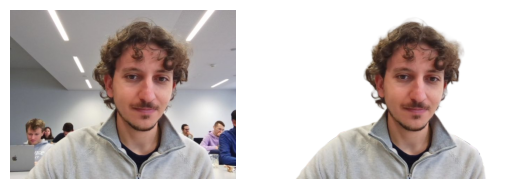

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('photo.jpg')
img2 = mpimg.imread('photo_no_bg.png')

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img1)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].axis('off')

plt.show()

# HuggingFace 🤗

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00


## Table Extraction

https://huggingface.co/microsoft/table-transformer-detection

In [ ]:
from google.colab import files
files.upload()

Saving table.png to table.png


{'table.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05F\x00\x00\x04&\x08\x06\x00\x00\x00\xfc\xc2e\x8f\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00 \x00IDATx^\xec\xbd\x05\xb8uE\xd9\x80=\x84\x88\xa8HI\n\x82t)\xdd\xa1 \xd2 \x82\x84t)\xdd"\n\x08\x92J* \x8d\x84\x94\x94\xd2\x1d\xd2\x8d\x84\x844\x88\x80Hw|\xf0\xff\xf7|\xff\xf3\xfe\xcb\xfd\x9d\xf3\x9e\xdc\xe7\x9c\xd9s\xaf\xeb:\xd7\x89\xbd\xf6\xac\x99\xfb\x99\xb5\xd6\x99{=3{\x8c\xe4&\x01\tH\xa0\x10\x02\x07\x1cp\xc0g\x13L0A\x1aw\xdcq\xd3\'\x9f|\x92>\xfd\xf4\xd3\xf4\xd9g\x9f\xe5/7\tH@\x02\x12\x90\x80\x04$ \x01\tH`\xf8\x08\x8c5\xd6X\xf9\xe0\x1f~\xf8az\xef\xbd\xf7\xd2n\xbb\xed6\xc6\xf0\xd5\xc6#K@\x02\x12\xe8\x1d\x01/T\xbd\xe3\xe4^\x12\x90\xc0\x08 p\xf4\xd1G\x7f6\xf3\xcc3\xa7)\xa6\x98\xe2\xbf\xa4\xe8\x18c\x8c\x91\xc6\x1cs\xcc\x11PC\xab \x01\tH@\x02\x12\x90\x80\x04$ \x81z\t\x90\xbc\xf0\xcc3\xcf\xa4\x17^x!m\xb5\xd5V\xfa\x86z\xbb\x82-\x97@1\x04\xbcP\x15\x13*+*\x01\t\x9cr\xca)\x9f-\xb0\xc0\x02i\x86\x19f\xc8b\x14\x19:\xf6\xd8c\'\xc4\xa8\x9b\x

In [ ]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image
import json

file_path = "table.png"
image = Image.open(file_path).convert("RGB")

# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("object-detection", model="microsoft/table-transformer-detection")
outputs = pipe(image)

print(json.dumps(outputs, indent=4))

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern 

[
    {
        "score": 0.9914633631706238,
        "label": "table",
        "box": {
            "xmin": 382,
            "ymin": 363,
            "xmax": 966,
            "ymax": 425
        }
    }
]


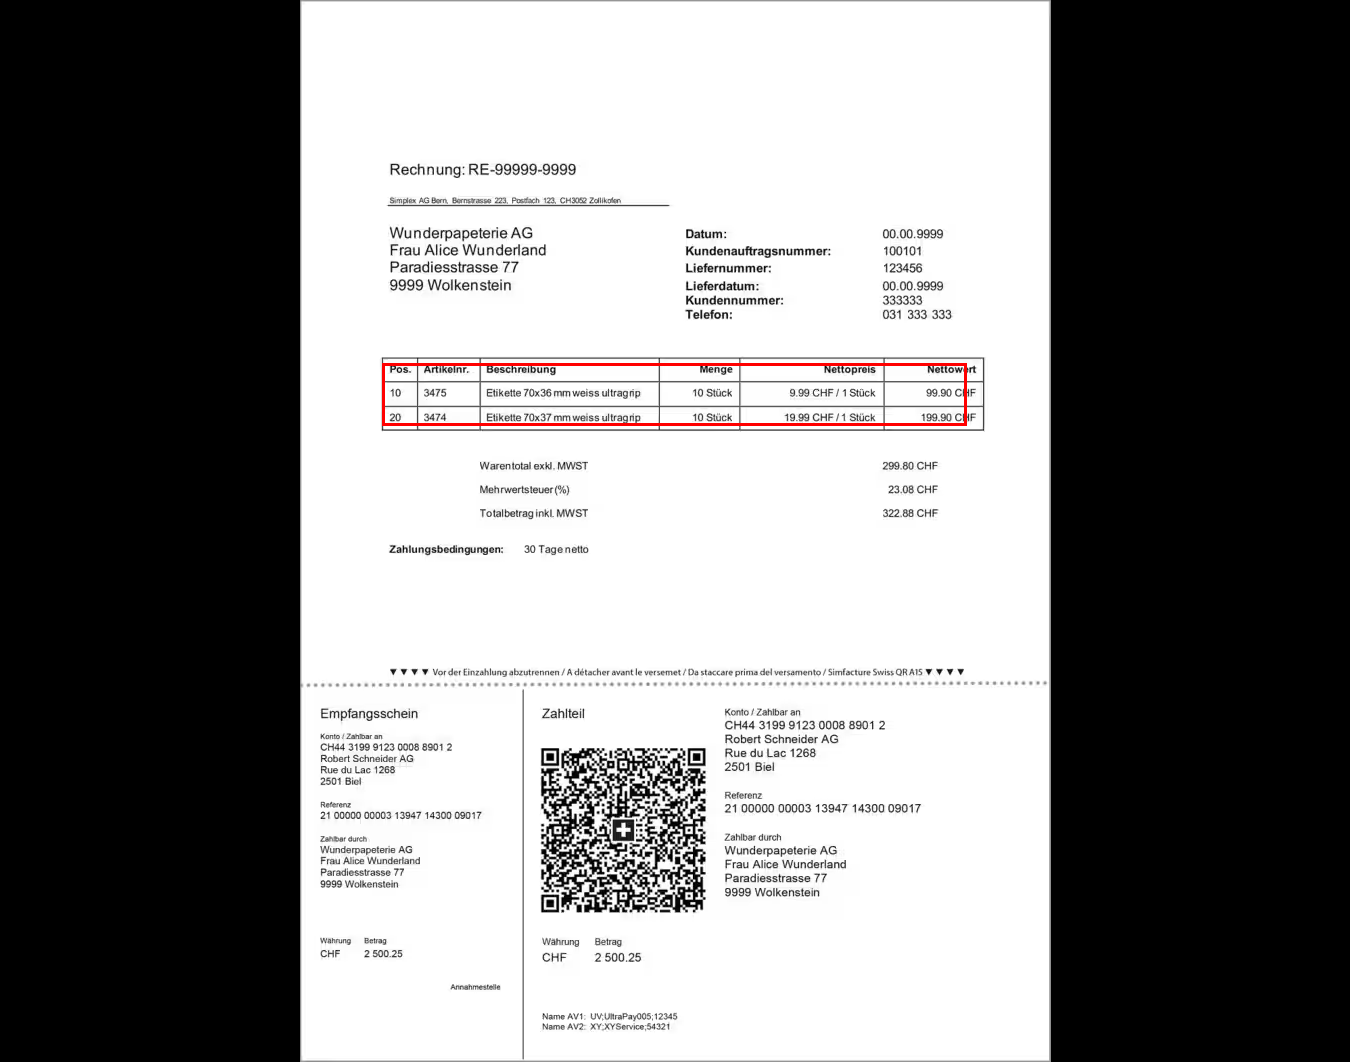

In [ ]:
from PIL import Image, ImageDraw

for table in outputs:
  box = table['box']
  xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']

  # Create a drawing context
  draw = ImageDraw.Draw(image)

  # Specify the bounding box color and width
  box_color = 'red'  # Color of the box
  box_width = 3      # Width of the box lines

  # Draw the bounding box
  draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=box_color, width=box_width)

image

## Half a Million AIs

https://huggingface.co/models

# UP NEXT

[NLP Text Classification](https://colab.research.google.com/drive/19u8-3_avmdwyRrhjX4XLdgtv3PC4Y8r8?usp=sharing)